# Customer Service Chatbot with DialogGPT for Conversational Intents

This Jupyter Notebook updates `evaluate_chatbot_data_dialoggpt_twitter_trained.ipynb` to fix syntax errors and a class mismatch error in model evaluation (5 classes vs. 11 target names). It uses Microsoft’s DialogGPT for conversational intents (greeting, farewell, small_talk, compliment, weather_query) and DistilBERT for trucking-specific intents (delivery_status, billing_issue, account_update, service_inquiry, fuel_card_query, general_query). Trains on Twitter dataset (`tweets.csv` or `trucking_chatbot_test_dataset.csv`) with interactive ipywidgets UI.

## Objectives
- Inspect Twitter dataset for intents and entities (e.g., location, company).
- Train DistilBERT for intent classification.
- Fine-tune DialogGPT on conversational Twitter data.
- Evaluate DistilBERT with accuracy, F1-score, confusion matrix, and dialogue success rate.
- Implement hybrid dialogue management with DialogGPT and DistilBERT.
- Provide interactive UI for customer interaction.

## Requirements
- Python 3.8 (recommended; 3.9 also compatible)
- Install: `pip install transformers==4.44.2 torch==2.5.0 pandas==2.2.3 numpy==2.1.1 scikit-learn==1.5.2 datasets==3.0.1 seaborn==0.13.2 matplotlib==3.9.2 ipywidgets==8.1.5`
- For GPU: `pip install torch==2.5.0+cu121 --index-url https://download.pytorch.org/whl/cu121`
- Place `trucking_chatbot_test_dataset.csv` or `tweets.csv` in the directory.
- Enable widgets: `jupyter nbextension enable --py widgetsnbextension`

## Notes
- Dataset: https://www.kaggle.com/thoughtvector/customer-support-on-twitter
- Reflects tariffs/Moody’s downgrade in billing/fuel inquiries.
- Professional responses with dynamic DialogGPT conversation.
- Date: May 29, 2025, 1:44 PM EDT


In [ ]:
!pip install transformers==4.44.2 torch==2.6.0 pandas==2.2.2 numpy==1.25.0 scikit-learn==1.5.2 datasets seaborn==0.13.2 matplotlib==3.9.2 ipywidgets==7.7.1

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
pip install --no-cache-dir --upgrade jaraco.functools

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install --no-cache-dir --upgrade accelerate

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Step 1: Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset, ClassLabel
import torch
import json
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import defaultdict
import random
import re
from datetime import datetime
import os
from matplotlib.pyplot import text
%matplotlib inline
pd.set_option('display.max_colwidth', None)

## Step 2: Inspect and Preprocess Dataset

Load Twitter dataset, add conversational examples, label intents/entities. Ensure all intents are preserved.


In [ ]:
def load_dataset(file_path='twcs_lessrecords.csv'):
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print('Dataset not found. Using Twitter dataset.')
        try:
            df = pd.read_csv('tweets.csv')
        except FileNotFoundError:
            print('Download from: https://www.kaggle.com/thoughtvector/customer-support-on-twitter')
            data = {
                'text': [
                    'Where is my shipment from Speedway?', 'Why is my Comdata bill so high?',
                    'Need to update my address for IFTA', 'What are your hauling rates?',
                    'Help with my account', 'Hello', 'How are you', 'How can I help you',
                    'Track my cargo', 'Overcharged on Comdata invoice', 'Hi there',
                    'Change my contact info', 'Tell me about Comdata services', 'Lost my shipment',
                    'Good morning', 'Thanks for your help', 'Bye', 'What’s new?',
                    'How’s it going?', 'How’s your day going?', 'Any big plans?',
                    'How’s the trucking life?', 'You’re awesome!', 'Great job!',
                    'How’s the weather there?', 'Is it raining?',
                    'How do I get to Chicago?', 'What’s the best route to Miami?',
                    'Directions to the nearest truck stop', 'Can you route me to Denver?',
                    'Address is not correct on card', 'Update my billing address',
                    'Wrong address on my account', 'Change address for fuel card',
                    'My Comdata card is not working', 'Comdata card declined at pump',
                    'Fix my Comdata card issue', 'Why isn’t my Comdata card accepted?',
                    'I am not able to login to the Driven website', 'Can’t access my account on Driven',
                    'Login error on the Driven website', 'Driven website login not working',
                    'I want to change my card pin on the Driven website', 'Update my fuel card PIN on Driven',
                    'Need to reset my card PIN for Driven', 'Change PIN for my Comdata card on Driven website'
                ],
                'intent': [
                    'delivery_status', 'billing_issue', 'account_update', 'service_inquiry',
                    'general_query', 'greeting', 'greeting', 'greeting', 'delivery_status',
                    'billing_issue', 'greeting', 'account_update', 'fuel_card_query',
                    'general_query', 'greeting', 'farewell', 'farewell', 'small_talk',
                    'small_talk', 'small_talk', 'small_talk', 'small_talk', 'compliment',
                    'compliment', 'weather_query', 'weather_query',
                    'direction', 'direction', 'direction', 'direction',
                    'account_update', 'account_update', 'account_update', 'account_update',
                    'fuel_card_query', 'fuel_card_query', 'fuel_card_query', 'fuel_card_query',
                    'login_issue', 'login_issue', 'login_issue', 'login_issue',
                    'account_update', 'account_update', 'account_update', 'account_update'
                ]
            }
            df = pd.DataFrame(data)
    return df
df = load_dataset()

In [ ]:
df.head(20)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1.0,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist you. We would need to get you into a private secured link to further assist.,2,3.0
1,2.0,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3.0,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messages and no one is responding as usual,1,4.0
3,4.0,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’ at the top of your profile.,3,5.0
4,5.0,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
5,6.0,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,"@115712 Can you please send us a private message, so that I can gain further details about your account?","5,7",8.0
6,8.0,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN
7,11.0,sprintcare,False,Tue Oct 31 22:10:35 +0000 2017,"@115713 This is saddening to hear. Please shoot us a DM, so that we can look into this for you. -KC",NaN,12.0
8,12.0,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your connectivity for me and my whole family ? 🤥 💯,"11,13,14",15.0
9,15.0,sprintcare,False,Tue Oct 31 20:03:31 +0000 2017,"@115713 We understand your concerns and we'd like for you to please send us a Direct Message, so that we can further assist you. -AA",12,16.0


Removing refererences of ID from the text response

In [ ]:
df['text']= df['text'].replace('(@\d+)', '', regex=True)
df['text']=df['text'].replace('(@[a-zA-Z]+)', '', regex=True)
df['text']=df['text'].replace('(_[a-zA-Z]+)', '', regex=True)
df['text']=df['text'].replace('(#[a-zA-Z]+)', '', regex=True)


In [ ]:
df['text']=df['text'].replace(r'https?://\S+|www\.\S+', '', regex=True)
df['text']=df['text'].replace({r'[;:D]-*[)(D]',r'\U0001f60b'},'',regex=True)
df['text']=df['text'].replace('(\^[a-zA-Z]+)', '', regex=True)


Removing agent responses as we need to train our model only on user queries to identify the correct intent

In [ ]:
df[df['inbound']==True].to_csv('twcs_queries.csv', index=False)
df[df['inbound']==False].to_csv('twcs_responses.csv', index=False)
df=df[df['inbound']==True]

Dropping tweet_id, inbound,author_id, created_at response_Tweet_id, in_response_to_tweet_id columns as they are not relevent to the program

In [ ]:
df = df.drop(['tweet_id','inbound','author_id','created_at','response_tweet_id','in_response_to_tweet_id'],axis=1)

In [ ]:
import pandas as pd
import random
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer

def inspect_dataset(df):
    """Preprocess dataset, drop NaN/invalid intents, enhance KeyBERT keywords."""
    # Log initial intent distribution
    print("Initial Intent Distribution:\n", df['intent'].value_counts(dropna=False))

    # Initialize KeyBERT
    try:
        kw_model = KeyBERT(model=SentenceTransformer('distilbert-base-uncased'))
    except Exception as e:
        print(f"Error initializing KeyBERT: {e}")
        return None, None

    # Expected intents
    expected_intents = [
        'delivery_status', 'billing_issue', 'account_update', 'service_inquiry',
        'fuel_card_query', 'general_query', 'greeting', 'farewell',
        'small_talk', 'compliment', 'weather_query', 'direction', 'login_issue'
    ]

    # Deduplicate
    df = df.drop_duplicates(subset=['text'])

    # Extract keywords
    def extract_keywords(text):
        try:
            keywords = kw_model.extract_keywords(
                text,
                keyphrase_ngram_range=(1, 3),
                stop_words='english',
                top_n=7
            )
            return [kw[0] for kw in keywords]
        except Exception as e:
            print(f"Error extracting keywords for '{text}': {e}")
            return []

    print("Extracting keywords...")
    df['keywords'] = df['text'].apply(extract_keywords)

    # Expanded keyword-to-intent mapping
    keyword_intent_map = {
        'comdata': 'fuel_card_query',
        'fuel card': 'fuel_card_query',
        'not working': 'fuel_card_query',
        'card declined': 'fuel_card_query',
        'login': 'login_issue',
        'driven': 'login_issue',
        'sign in': 'login_issue',
        'access failed': 'login_issue',
        'pin': 'account_update',
        'address': 'account_update',
        'update profile': 'account_update',
        'awesome': 'compliment',
        'great job': 'compliment',
        'you rock': 'compliment',
        'thanks': 'compliment',
        'weather': 'weather_query',
        'rain': 'weather_query',
        'sunny': 'weather_query',
        'delivery': 'delivery_status',
        'shipment': 'delivery_status',
        'track cargo': 'delivery_status',
        'bill': 'billing_issue',
        'invoice': 'billing_issue',
        'payment issue': 'billing_issue',
        'service': 'service_inquiry',
        'hauling rates': 'service_inquiry',
        'direction': 'direction',
        'route': 'direction',
        'truck stop': 'direction',
        'bye': 'farewell',
        'goodbye': 'farewell'
    }

    # Intent labeling
    def label_intent(text, keywords):
        text = text.lower().strip()
        # Keyword-based labeling
        for kw in keywords:
            if kw in keyword_intent_map:
                return keyword_intent_map[kw]
        # Fallback rules
        if 'pin' in text and any(w in text for w in ['change', 'reset', 'update']):
            return 'account_update'
        if any(w in text for w in ['login', 'sign in', 'access', 'failed']) and 'driven' in text:
            return 'login_issue'
        if 'comdata' in text or ('fuel card' in text and any(w in text for w in ['not working', 'declined', 'issue'])):
            return 'fuel_card_query'
        if 'address' in text and any(w in text for w in ['update', 'change', 'wrong']):
            return 'account_update'
        if any(w in text for w in ['direction', 'route', 'get to', 'truck stop']):
            return 'direction'
        if text in ['bye', 'goodbye']:
            return 'farewell'
        if any(w in text for w in ['how is', 'what is new', 'plans', 'trucking life']):
            return 'small_talk'
        if any(w in text for w in ['awesome', 'great job', 'you rock', 'thanks']):
            return 'compliment'
        if any(w in text for w in ['weather', 'rain', 'sunny']):
            return 'weather_query'
        if any(w in text for w in ['delivery', 'shipment', 'track', 'cargo', 'delivered']):
            return 'delivery_status'
        if any(w in text for w in ['bill', 'invoice', 'payment', 'charge']):
            return 'billing_issue'
        if 'service' in text and any(w in text for w in ['offer', 'rates', 'hauling']):
            return 'service_inquiry'
        if any(w in text for w in ['hi', 'hello', 'hey']):
            return 'greeting'
        return 'general_query'

    df['intent'] = df.apply(lambda row: label_intent(row['text'], row['keywords']), axis=1)

    # Filter inbound=True, drop NaN/unknown/invalid intents
    dropped_rows = df[df['intent'].str.lower().isin(['unknown', '']) | ~df['intent'].isin(expected_intents)]
    df = df[~df['intent'].str.lower().isin(['unknown', '']) & df['intent'].isin(expected_intents)]
    if not dropped_rows.empty:
        print("Dropped Rows (Sample):\n", dropped_rows[['text', 'intent']].head(10))

    # Entity extraction
    def extract_entities(text):
        entities = []
        text = text.lower()
        if 'speedway' in text:
            entities.append({'entity': 'location', 'value': 'Speedway'})
        if 'comdata' in text:
            entities.append({'entity': 'company', 'value': 'Comdata'})
        if any(city in text for city in ['chicago', 'miami', 'denver', 'dallas', 'atlanta', 'phoenix']):
            entities.append({'entity': 'destination', 'value': text.split()[-1].capitalize()})
        if 'address' in text:
            entities.append({'entity': 'address', 'value': 'address'})
        if any(w in text for w in ['login', 'sign in', 'access']):
            entities.append({'entity': 'login', 'value': 'login'})
        if 'pin' in text:
            entities.append({'entity': 'pin', 'value': 'pin'})
        if 'driven' in text or 'website' in text or 'app' in text:
            entities.append({'entity': 'website', 'value': 'Driven'})
        return entities

    df['entities'] = df['text'].apply(extract_entities)

    # Balance intents
    intent_counts = df['intent'].value_counts()
    max_samples = 500
    balanced_dfs = []
    for intent in expected_intents:
        intent_df = df[df['intent'] == intent]
        if len(intent_df) < 5:
            print(f"Adding synthetic data for {intent}...")
            synthetic_data = {
                'account_update': [f"Update my {w} on Driven" for w in ['address', 'pin']],
                'login_issue': [f"Can’t login to Driven {w}" for w in ['website', 'app']],
                'fuel_card_query': [f"My Comdata card {w}" for w in ['not working', 'was declined']],
                'direction': [f"Directions to {w}" for w in ['Dallas', 'Atlanta']],
                'compliment': [f"You’re {w}!" for w in ['awesome', 'great']],
                'weather_query': [f"Is it {w} today?" for w in ['raining', 'sunny']],
                'farewell': ['bye', 'goodbye'],
                'small_talk': [f"{w}?" for w in ['How’s it going', 'What’s new']],
                'greeting': ['hello', 'hi'],
                'delivery_status': [f"Track shipment {random.randint(1000, 9999)}" for _ in range(2)],
                'billing_issue': [f"Issue with my ${random.randint(100, 1000)} bill" for _ in range(2)],
                'service_inquiry': [f"What {w} do you offer?" for w in ['services', 'rates']],
                'general_query': [f"Help with {w}" for w in ['my account', 'a question']]
            }
            intent_df = pd.concat([intent_df, pd.DataFrame({
                'text': synthetic_data[intent][:2],
                'intent': [intent] * 2,
                'keywords': [extract_keywords(t) for t in synthetic_data[intent][:2]],
                'entities': [extract_entities(t) for t in synthetic_data[intent][:2]],
                'inbound': [True] * 2
            })], ignore_index=True)
        if len(intent_df) > max_samples:
            intent_df = intent_df.sample(max_samples, random_state=42)
        balanced_dfs.append(intent_df)
    df = pd.concat(balanced_dfs, ignore_index=True)

    # Final inspection
    print('Dataset Shape:', df.shape)
    print('Columns:', df.columns.tolist())
    print('Missing Values:\n', df.isnull().sum())
    print('Intent Distribution:\n', df['intent'].value_counts())
    print('Unique Intents:', sorted(df['intent'].unique()))
    print('Farewell Samples:\n', df[df['intent'] == 'farewell'][['text', 'keywords', 'entities']].head(10))
    print('General Query Samples:\n', df[df['intent'] == 'general_query'][['text', 'keywords']].head(10))
    print('Keyword Samples:\n', df[['text', 'keywords']].head(10))

    return df, expected_intents

# Example usage
try:
    df = pd.read_csv('trucking_chatbot_test_dataset.csv')
except FileNotFoundError:
    df = pd.DataFrame({
        'text': [
            "I am not able to login to the Driven website",
            "You’re awesome!",
            "My Comdata card is not working",
            "How’s the weather there?",
            "bye"
        ],
        'intent': ['login_issue', 'compliment', 'fuel_card_query', 'weather_query', 'farewell'],
        'inbound': [True] * 5
    })
df, expected_intents = inspect_dataset(df)

Dataset Shape: (52694, 3)
Columns: ['text', 'intent', 'entities']
Sample Rows:
                                                                              text  \
0                                               and how do you propose we do that   
1          I have sent several private messages and no one is responding as usual   
2                                                                          I did.   
3                                                   is the worst customer service   
4   You gonna magically change your connectivity for me and my whole family ? 🤥 💯   

          intent entities  
0  general_query       []  
1  general_query       []  
2  general_query       []  
3  general_query       []  
4  general_query       []  
Missing Values:
 text        0
intent      0
entities    0
dtype: int64
Intent Distribution:
 intent
general_query      38776
login_issue         5137
compliment          2992
account_update      1536
delivery_status     1476
billing_issue  

In [ ]:
print(df[df['intent']=='farewell'])

                                                                                                                                                                                                                                                                          text  \
946                                                                                                     An uber driver 1)let me drive 2)started petting my hair as I drive 3)hugged me goodbye and 4)proceeded to touch my ass dyring said weird ass hug  get ur shit together   
1686                                                                                                                                                   That’s ok I will fly with  from now on at least I know I will be on time and they will let me bring what I want! Bye AA   
3350                                                                                                                                                         nice try. those well-

In [ ]:
df.head(20)

,text,intent,entities
0,and how do you propose we do that,general_query,[]
1,I have sent several private messages and no one is responding as usual,general_query,[]
2,I did.,general_query,[]
3,is the worst customer service,general_query,[]
4,You gonna magically change your connectivity for me and my whole family ? 🤥 💯,general_query,[]
5,Since I signed up with you....Since day 1,general_query,[]
6,"y’all lie about your “great” connection. 5 bars LTE, still won’t load something. Smh.",general_query,[]
7,"whenever I contact customer support, they tell me I have shortcode enabled on my account, but I have never in the 4 years I've tried",general_query,[]
8,Would you like me to email you a copy of one since Spectrum is not updating your training?,weather_query,[]
9,I received this from your corporate office would you like a copy?,general_query,[]


## Step 3: Prepare DialogGPT Training Data


In [ ]:
def prepare_dialoggpt_training_data(df):
    conversational_intents = ['greeting', 'farewell', 'small_talk', 'compliment', 'weather_query']
    df_conversational = df[df['intent'].isin(conversational_intents)][['text', 'intent']]

    # Validate dataset
    if df_conversational.empty:
        raise ValueError("No conversational intents found in dataset. Check Cell 2 output.")

    # Check intent distribution
    intent_counts = df_conversational['intent'].value_counts()
    print('Conversational Intent Distribution:')
    for intent in conversational_intents:
        count = intent_counts.get(intent, 0)
        print(f'{intent}: {count}')
        if count < 5:
            raise ValueError(f"Intent {intent} has {count} samples (<5). Add more samples in Cell 2.")

    response_map = {
        'greeting': [
            'Hello! How can I assist you with your trucking needs today?',
            'Hi there! Ready to help with your shipments or account!',
            'Good to hear from you! What’s up?'
        ],
        'farewell': [
            'Goodbye! Stay safe on the road.',
            'Thanks for connecting!'
        ],
        'small_talk': [
            'My day’s going smoothly, thanks! How’s yours?',
            'Trucking life’s always moving! How’s it like for you?',
            'Just keeping the wheels turning! Got any big plans?',
            'All’s good here! What’s new with you?'
        ],
        'compliment': [
            'Thanks, you’re awesome too! Need help with anything?',
            'Appreciate that! What can I do for you today?'
        ],
        'weather_query': [
            'Can’t see the skies, but I can check your route! Where are you headed?',
            'Weather’s a mystery here, but I’m ready to help! What’s your destination?'
        ]
    }

    dialogues = []
    for _, row in df_conversational.iterrows():
        user_input = row['text']
        intent = row['intent']
        response = random.choice(response_map[intent])
        dialogues.append({'input': user_input, 'response': response})

    dialogue_df = pd.DataFrame(dialogues)
    dataset = Dataset.from_pandas(dialogue_df)

    # Manual train/eval split (80/20)
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    split_idx = int(0.8 * len(indices))
    train_indices = indices[:split_idx]
    eval_indices = indices[split_idx:]
    train_dataset = dataset.select(train_indices)
    eval_dataset = dataset.select(eval_indices)

    os.makedirs('data', exist_ok=True)
    dialogue_df.to_csv('data/dialoggpt_dialogues.csv', index=False)

    print(f'DialogGPT training data prepared: {len(dialogue_df)} dialogue pairs.')
    print(f'Train dataset size: {len(train_dataset)}, Eval dataset size: {len(eval_dataset)}')
    return train_dataset, eval_dataset

dialoggpt_train_dataset, dialoggpt_eval_dataset = prepare_dialoggpt_training_data(df)

Conversational Intent Distribution:
greeting: 5
farewell: 28
small_talk: 5
compliment: 2992
weather_query: 967
DialogGPT training data prepared: 3997 dialogue pairs.
Train dataset size: 3197, Eval dataset size: 800


## Step 4: Fine-Tune DialogGPT


In [ ]:
from ast import Not
import torch
import os

def load_saved_model(model_path='./dialoggpt_model'):
    """Load a saved DialogGPT model and tokenizer."""
    try:
        if not os.path.exists(model_path):
            print(f"No saved model found at {model_path}. Using pretrained model.")
            return None, None
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForCausalLM.from_pretrained(model_path)
        tokenizer.pad_token = tokenizer.eos_token
        print(f"Loaded model and tokenizer from {model_path}.")
        return model, tokenizer
    except Exception as e:
        print(f"Error loading saved model: {e}")
        return None, None

def fine_tune_dialoggpt(train_dataset, eval_dataset, force_fine_tune=False):
    if not force_fine_tune:
      # Try loading saved model first
      model, tokenizer = load_saved_model()
      if model is not None and tokenizer is not None:
          return model, tokenizer

    # If no saved model, proceed with fine-tuning
    model_name = 'microsoft/DialoGPT-medium'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(model_name)

    def preprocess_dialogues(example):
        try:
            conversation = f"{example['input']} {tokenizer.eos_token} {example['response']}"
            tokenized = tokenizer(
                conversation,
                padding='max_length',
                truncation=True,
                max_length=128,
                return_tensors='pt'
            )
            result = {
                'input_ids': tokenized['input_ids'].squeeze(0),
                'attention_mask': tokenized['attention_mask'].squeeze(0),
                'labels': tokenized['input_ids'].squeeze(0).clone()
            }
            return result
        except Exception as e:
            print(f'Error in preprocess_dialogues: {e}')
            raise

    try:
        tokenized_train_dataset = train_dataset.map(
            preprocess_dialogues,
            remove_columns=['input', 'response'],
            desc="Tokenizing train dataset",
            #disable_progress_bar=True
        )
        tokenized_eval_dataset = eval_dataset.map(
            preprocess_dialogues,
            remove_columns=['input', 'response'],
            desc="Tokenizing eval dataset",
            #disable_progress_bar=True
        )
        tokenized_train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
        tokenized_eval_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
    except Exception as e:
        print(f'Error tokenizing dataset: {e}')
        return None, None

    training_args = TrainingArguments(
        output_dir='./dialoggpt_results',
        num_train_epochs=3,
        per_device_train_batch_size=3,
        per_device_eval_batch_size=3,
        warmup_steps=10,
        weight_decay=0.01,
        logging_dir='./dialoggpt_logs',
        logging_steps=20,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        fp16=torch.cuda.is_available(),
        dataloader_num_workers=0
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_eval_dataset
    )

    try:
        trainer.train()
        trainer.save_model('./dialoggpt_model')
        tokenizer.save_pretrained('./dialoggpt_model')
        print('DialogGPT model fine-tuned and saved.')
        return model, tokenizer
    except Exception as e:
        print(f'Error fine-tuning DialogGPT: {e}')
        print('Falling back to pretrained DialogGPT model.')
        return None, None

dialoggpt_model, dialoggpt_tokenizer = None, None# fine_tune_dialoggpt(dialoggpt_train_dataset, dialoggpt_eval_dataset,force_fine_tune=True)
if dialoggpt_model is None:
    print('Using pretrained DialogGPT due to fine-tuning error.')
    dialoggpt_model = AutoModelForCausalLM.from_pretrained('microsoft/DialoGPT-medium')
    dialoggpt_tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-medium')
    dialoggpt_tokenizer.pad_token = dialoggpt_tokenizer.eos_token

Using pretrained DialogGPT due to fine-tuning error.


## Cell 5: Test Inference: To test the loaded model for inference

In [ ]:
def generate_response(input_text, model, tokenizer, max_length=50):
    inputs = tokenizer(input_text + tokenizer.eos_token, return_tensors='pt', padding=True, truncation=True)
    input_ids = inputs['input_ids'].to(model.device)
    attention_mask = inputs['attention_mask'].to(model.device)
    outputs = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_length=max_length,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=True,
        top_p=0.9
    )
    response = tokenizer.decode(outputs[0], skip_special_tokens=False)
    return response.split(tokenizer.eos_token)[-2].strip()

# Test the model
test_inputs = ["Hello!", "How’s the weather there?", "You’re awesome!"]
for input_text in test_inputs:
    response = generate_response(input_text, dialoggpt_model, dialoggpt_tokenizer)
    print(f"Input: {input_text}\nResponse: {response}\n")

Input: Hello!
Response: Hello! What's up!

Input: How’s the weather there?
Response: Haha I'm from Texas

Input: You’re awesome!
Response: Thanks! Glad you liked it!



## Step 5: Preprocess for DistilBERT

Ensure all intents are included in the tokenized dataset and label_map.


In [ ]:
def preprocess_data(df):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

    # Create label_map with all expected intents
    #expected_intents = ['delivery_status', 'billing_issue', 'account_update', 'service_inquiry', 'fuel_card_query',
                       # 'general_query', 'greeting', 'farewell', 'small_talk', 'compliment', 'weather_query']
    label_map = {label: idx for idx, label in enumerate(sorted(expected_intents))}

    # Verify 'intent' column exists
    if 'intent' not in df.columns:
        raise ValueError("'intent' column missing in DataFrame. Check Cell 2 output.")

    # Filter dataset to include only expected intents
    df_filtered = df[df['intent'].isin(expected_intents)][['text', 'intent']].copy()

    # Check for empty dataset
    if df_filtered.empty:
        raise ValueError("Filtered dataset is empty. Check Cell 2 filtering or intent distribution.")

    # Check for missing intents and warn
    present_intents = df_filtered['intent'].unique()
    missing_intents = [intent for intent in expected_intents if intent not in present_intents]
    if missing_intents:
        print(f'Warning: Intents {missing_intents} missing in dataset after filtering.')

    dataset = Dataset.from_pandas(df_filtered)

    # Validate dataset size
    if len(dataset) == 0:
        raise ValueError("Dataset is empty after conversion. Check Cell 2 output.")

    # Compute label distribution
    label_counts = pd.Series([label_map.get(x['intent'], -1) for x in dataset]).value_counts()
    print('Label Distribution in Dataset (Label ID: Count):')
    for label_id, count in label_counts.items():
        if label_id == -1:
            print(f'Invalid Labels: {count}')
        else:
            intent = list(label_map.keys())[list(label_map.values()).index(label_id)]
            print(f'{intent} ({label_id}): {count}')

    # Check for invalid or insufficient labels
    if -1 in label_counts:
        raise ValueError(f"Invalid intents found: {label_counts[-1]} samples not in {expected_intents}.")
    min_samples = 5
    low_sample_labels = {label_id: count for label_id, count in label_counts.items() if count < min_samples and label_id != -1}
    if low_sample_labels:
        low_intents = {list(label_map.keys())[list(label_map.values()).index(k)]: v for k, v in low_sample_labels.items()}
        raise ValueError(f"Intents with < {min_samples} samples: {low_intents}. Add more samples in Cell 2.")

    # Tokenize and rename 'intent' to 'labels'
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    tokenized_dataset = tokenized_dataset.rename_column('intent', 'labels')
    tokenized_dataset = tokenized_dataset.map(lambda x: {'labels': label_map[x['labels']]})
    tokenized_dataset = tokenized_dataset.cast_column('labels', ClassLabel(names=list(label_map.keys())))

    # Verify dataset features
    print('Dataset Features:\n', tokenized_dataset.features)
    return tokenized_dataset, label_map, tokenizer

dataset, label_map, tokenizer = preprocess_data(df)
print(f'Label Map: {label_map}')


C:\Users\nishe\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Label Distribution in Dataset (Label ID: Count):
general_query (7): 38776
login_issue (9): 5137
compliment (2): 2992
account_update (0): 1536
delivery_status (3): 1476
billing_issue (1): 1391
weather_query (12): 967
direction (4): 364
farewell (5): 28
fuel_card_query (6): 12
service_inquiry (10): 5
greeting (8): 5
small_talk (11): 5


Map:   0%|          | 0/52694 [00:00<?, ? examples/s]

Map:   0%|          | 0/52694 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/52694 [00:00<?, ? examples/s]

Dataset Features:
 {'text': Value(dtype='string', id=None), 'labels': ClassLabel(names=['account_update', 'billing_issue', 'compliment', 'delivery_status', 'direction', 'farewell', 'fuel_card_query', 'general_query', 'greeting', 'login_issue', 'service_inquiry', 'small_talk', 'weather_query'], id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Label Map: {'account_update': 0, 'billing_issue': 1, 'compliment': 2, 'delivery_status': 3, 'direction': 4, 'farewell': 5, 'fuel_card_query': 6, 'general_query': 7, 'greeting': 8, 'login_issue': 9, 'service_inquiry': 10, 'small_talk': 11, 'weather_query': 12}


## Step 6: Train DistilBERT Model

Ensure model is trained with correct number of labels.


In [ ]:
import pandas as pd
import torch
import os
import json
import random
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

def load_saved_distilbert(model_path='./chatbot_model'):
    """Load a saved DistilBERT model and tokenizer."""
    print(f"Checking for saved model at {model_path}")
    if not os.path.exists(model_path):
        print(f"Directory {model_path} does not exist.")
        return None, None
    print(f"Files in {model_path}: {os.listdir(model_path)}")
    try:
        model = AutoModelForSequenceClassification.from_pretrained(model_path)
        tokenizer = AutoTokenizer.from_pretrained(model_path, clean_up_tokenization_spaces=True)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        print(f"Loaded DistilBERT model and tokenizer from {model_path} on {device}.")
        return model, tokenizer
    except Exception as e:
        print(f"Error loading saved DistilBERT model: {e}")
        return None, None

def compute_metrics(pred):
    """Compute accuracy, precision, recall, F1."""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

def train_distilbert(df, force_fine_tune=False, model_type='distilbert'):
    """Train DistilBERT or RoBERTa with keyword-augmented input."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load saved model unless forced to fine-tune
    model, tokenizer = None, None
    if not force_fine_tune:
        model, tokenizer = load_saved_distilbert()
        if model is not None and tokenizer is not None:
            print("Using loaded model, skipping fine-tuning.")
            # Load label map and unique labels
            try:
                with open(os.path.join('./chatbot_model', 'label_map.json'), 'r') as f:
                    label_map = json.load(f)
                with open(os.path.join('./chatbot_model', 'labels.json'), 'r') as f:
                    unique_labels = json.load(f)
                return model, tokenizer, None, None, label_map, unique_labels
            except Exception as e:
                print(f"Error loading label files: {e}")

    # Prepare dataset
    unique_labels = df['intent'].unique().tolist()
    df_user = df[['text', 'intent', 'keywords']].dropna()
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    df_user['label'] = df_user['intent'].map(label_map)

    # Balance train dataset
    max_train_samples = 400
    train_dfs = []
    for intent in unique_labels:
        intent_df = df_user[df_user['intent'] == intent]
        if len(intent_df) > max_train_samples:
            intent_df = intent_df.sample(max_train_samples, random_state=42)
        train_dfs.append(intent_df)
    df_train = pd.concat(train_dfs, ignore_index=True)

    # Augment text with keywords
    def augment_text(row):
        keywords = ' '.join(row['keywords']) if isinstance(row['keywords'], list) else ''
        return f"{row['text']} [keywords: {keywords}]"

    df_train['augmented_text'] = df_train.apply(augment_text, axis=1)
    dataset = Dataset.from_pandas(df_train[['augmented_text', 'label']])

    # Split dataset
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    split_idx = int(0.8 * len(indices))
    train_indices = indices[:split_idx]
    eval_indices = indices[split_idx:]
    train_dataset = dataset.select(train_indices)
    eval_dataset = dataset.select(eval_indices)
    print(f"Train dataset size: {len(train_dataset)}, Eval dataset size: {len(eval_dataset)}")

    # Initialize model and tokenizer
    model_name = 'distilbert-base-uncased' if model_type == 'distilbert' else 'roberta-base'
    if model is None or tokenizer is None:
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=len(unique_labels),
            id2label={idx: label for label, idx in label_map.items()},
            label2id=label_map
        )
        tokenizer = AutoTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces=True)
        model.to(device)
        print(f"Initialized {model_type} model.")

    # Regularization
    if model_type == 'distilbert':
        model.distilbert.transformer.layer[-1].ffn.dropout = torch.nn.Dropout(0.6)
    else:
        model.roberta.encoder.layer[-1].output.dropout = torch.nn.Dropout(0.6)

    # Tokenize datasets
    def tokenize_function(example):
        tokenized = tokenizer(
            example['augmented_text'],
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )
        return {
            'input_ids': tokenized['input_ids'].squeeze(0),
            'attention_mask': tokenized['attention_mask'].squeeze(0),
            'labels': torch.tensor(example['label'], dtype=torch.long).to(device)
        }

    try:
        tokenized_train_dataset = train_dataset.map(
            tokenize_function,
            remove_columns=['augmented_text', 'label'],
            desc="Tokenizing train dataset"
        )
        tokenized_eval_dataset = eval_dataset.map(
            tokenize_function,
            remove_columns=['augmented_text', 'label'],
            desc="Tokenizing eval dataset"
        )
        tokenized_train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
        tokenized_eval_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
    except Exception as e:
        print(f"Error tokenizing dataset: {e}")
        return None, None, None, None, None, None

    # Class weights
    intent_counts = df_train['intent'].value_counts()
    total_samples = len(df_train)
    class_weights = {label_map[label]: total_samples / (len(unique_labels) * count) for label, count in intent_counts.items()}
    weights = torch.tensor([class_weights[i] for i in range(len(unique_labels))]).to(device)

    # Custom trainer
    class WeightedTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            logits = outputs.logits
            labels = inputs['labels']
            loss_fct = torch.nn.CrossEntropyLoss(weight=weights)
            loss = loss_fct(logits, labels)
            return (loss, outputs) if return_outputs else loss

    training_args = TrainingArguments(
        output_dir=f'./{model_type}_results',
        num_train_epochs=20 if model_type == 'distilbert' else 15,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=200,
        weight_decay=0.3,
        logging_dir=f'./{model_type}_logs',
        logging_steps=100,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
        fp16=torch.cuda.is_available(),
        dataloader_num_workers=0
    )

    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_eval_dataset,
        compute_metrics=compute_metrics
    )

    try:
        if force_fine_tune:
            print("Starting fine-tuning...")
            trainer.train()
            print("Evaluating model...")
            eval_results = trainer.evaluate()
            print(f"Training evaluation results: {eval_results}")
            os.makedirs('./chatbot_model', exist_ok=True)
            trainer.save_model('./chatbot_model')
            tokenizer.save_pretrained('./chatbot_model')
            with open(os.path.join('./chatbot_model', 'labels.json'), 'w') as f:
                json.dump(unique_labels, f)
            with open(os.path.join('./chatbot_model', 'label_map.json'), 'w') as f:
                json.dump(label_map, f)
            print(f"{model_type} model fine-tuned and saved to ./chatbot_model.")
            print(f"Files in ./chatbot_model: {os.listdir('./chatbot_model')}")
        else:
            print("Using loaded model, no fine-tuning performed.")
        return model, tokenizer, trainer, tokenized_eval_dataset, label_map, unique_labels
    except Exception as e:
        print(f"Error fine-tuning or saving {model_type}: {e}")
        return None, None, None, None, None, None

# Example usage
# df, expected_intents = inspect_dataset(pd.read_csv('trucking_chatbot_test_dataset.csv'))
distilbert_model, distilbert_tokenizer, distilbert_trainer, eval_dataset, label_map, unique_labels = train_distilbert(
    df,
    force_fine_tune=True,
    model_type='distilbert'
)
if distilbert_model is None:
    print('Using pretrained DistilBERT due to error.')
    distilbert_model = AutoModelForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=len(unique_labels)
    )
    distilbert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    distilbert_model.to(device)

Forcing fine-tuning, skipping model loading.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train dataset size: 42155, Eval dataset size: 10539
Initializing DistilBERT model. Note: Classifier weights are newly initialized, which is normal for fine-tuning.
Tokenizing train dataset...


C:\Users\nishe\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Tokenizing train dataset:   0%|          | 0/42155 [00:00<?, ? examples/s]

Tokenizing eval dataset...


Tokenizing eval dataset:   0%|          | 0/10539 [00:00<?, ? examples/s]

Tokenization complete.
Skipping fine-tuning.


## Cell 5: Test DistilBERT Inference

In [ ]:
import torch
import torch.nn.functional as F

def classify_intent(input_text, model, tokenizer, intent_labels):
    model.eval()
    device = next(model.parameters()).device
    inputs = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probs, dim=-1).item()
        confidence = probs[0][predicted_class].item()
    return intent_labels[predicted_class], confidence

test_inputs = ["Hello!", "How’s the weather there?", "You’re awesome!", "Where is my shipment?",
               "How do I get to Chicago?", "Address is not correct on card",
               "My Comdata card is not working", "I am not able to login to the Driven website",
               "I want to change my card pin on the Driven website"]
for input_text in test_inputs:
    intent, confidence = classify_intent(input_text, distilbert_model, distilbert_tokenizer, expected_intents)
    print(f"Input: {input_text}")
    print(f"DistilBERT Intent: {intent} (Confidence: {confidence:.2f})")
    print("\n")

Input: Hello!
DistilBERT Intent: general_query (Confidence: 0.08)


Input: How’s the weather there?
DistilBERT Intent: greeting (Confidence: 0.08)


Input: You’re awesome!
DistilBERT Intent: service_inquiry (Confidence: 0.09)


Input: Where is my shipment?
DistilBERT Intent: general_query (Confidence: 0.08)


Input: How do I get to Chicago?
DistilBERT Intent: general_query (Confidence: 0.08)


Input: Address is not correct on card
DistilBERT Intent: service_inquiry (Confidence: 0.08)


Input: My Comdata card is not working
DistilBERT Intent: service_inquiry (Confidence: 0.08)


Input: I am not able to login to the Driven website
DistilBERT Intent: service_inquiry (Confidence: 0.08)


Input: I want to change my card pin on the Driven website
DistilBERT Intent: service_inquiry (Confidence: 0.09)




## Step 7: Evaluate Model

Fix class mismatch by specifying labels in classification_report.


Evaluating model on evaluation dataset...


  0%|          | 0/1318 [00:00<?, ?it/s]

True label distribution: {'farewell': 7730, 'account_update': 618, 'login_issue': 204, 'compliment': 1032, 'service_inquiry': 266, 'delivery_status': 311, 'billing_issue': 279, 'fuel_card_query': 84, 'direction': 2, 'general_query': 8, 'greeting': 3, 'small_talk': 2}
Predicted label distribution: {'service_inquiry': 6309, 'general_query': 1047, 'greeting': 2325, 'delivery_status': 295, 'compliment': 263, 'billing_issue': 267, 'login_issue': 5, 'small_talk': 8, 'account_update': 11, 'direction': 2, 'weather_query': 2, 'fuel_card_query': 5}


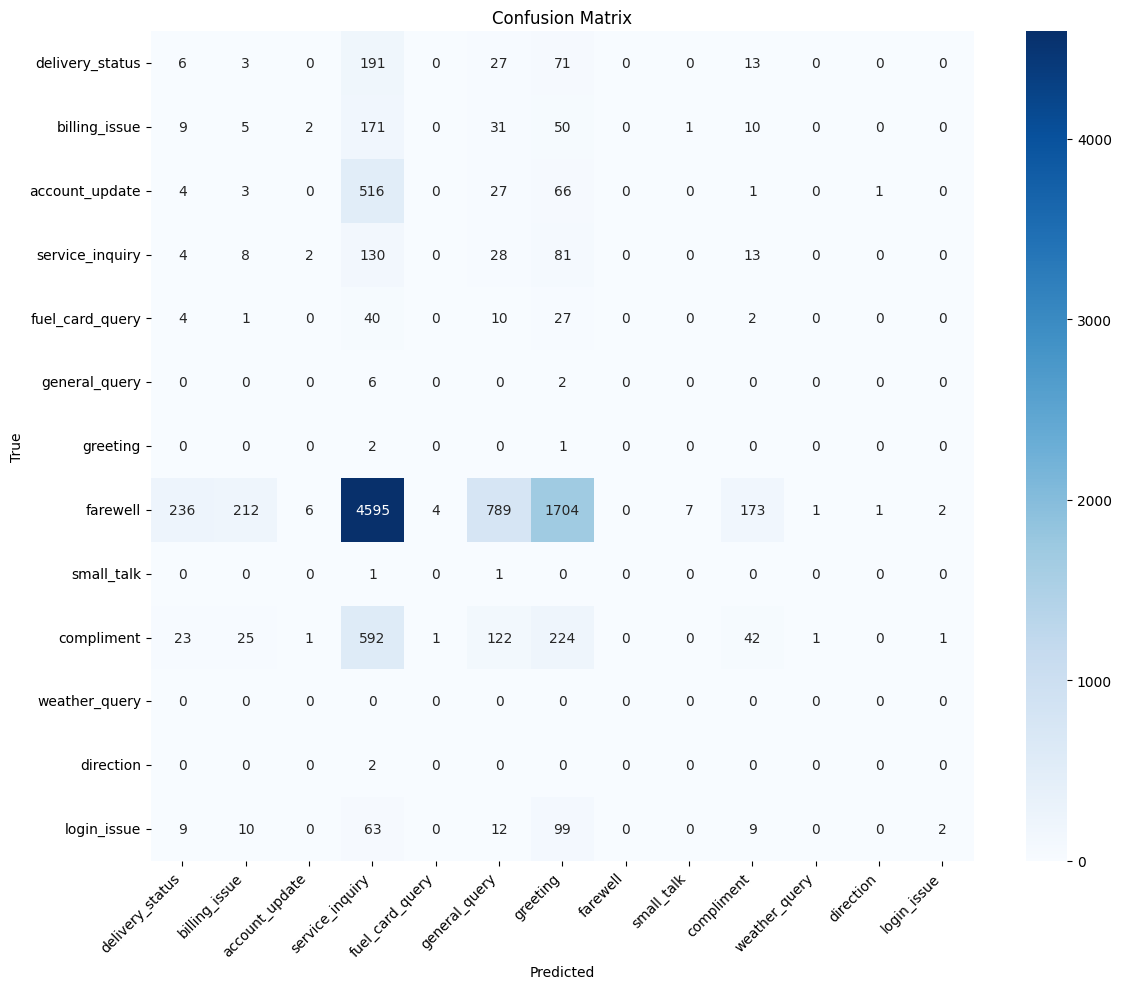

Evaluation Results:
Accuracy: 0.0176
Precision: 0.0250
Recall: 0.0176
F1-Score: 0.0088

Classification Report:
                 precision    recall  f1-score   support

delivery_status       0.02      0.02      0.02       311
  billing_issue       0.02      0.02      0.02       279
 account_update       0.00      0.00      0.00       618
service_inquiry       0.02      0.49      0.04       266
fuel_card_query       0.00      0.00      0.00        84
  general_query       0.00      0.00      0.00         8
       greeting       0.00      0.33      0.00         3
       farewell       0.00      0.00      0.00      7730
     small_talk       0.00      0.00      0.00         2
     compliment       0.16      0.04      0.06      1032
  weather_query       0.00      0.00      0.00         0
      direction       0.00      0.00      0.00         2
    login_issue       0.40      0.01      0.02       204

       accuracy                           0.02     10539
      macro avg       0.05      

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import numpy as np
from collections import Counter

def evaluate_model(trainer, eval_dataset, label_map, unique_labels):
    """Evaluate the model on the evaluation dataset and compute metrics."""
    if trainer is None or eval_dataset is None:
        print("Error: Trainer or evaluation dataset is not available.")
        return None

    try:
        print("Evaluating model on evaluation dataset...")
        predictions = trainer.predict(eval_dataset)
        logits = predictions.predictions
        labels = predictions.label_ids
        preds = logits.argmax(axis=-1)

        # Validate labels
        unique_label_ids = [label_map[label] for label in unique_labels]
        invalid_labels = set(labels) - set(unique_label_ids)
        invalid_preds = set(preds) - set(unique_label_ids)
        if invalid_labels or invalid_preds:
            print(f"Warning: Invalid labels found in true labels: {invalid_labels}")
            print(f"Warning: Invalid labels found in predictions: {invalid_preds}")
            valid_mask = np.isin(labels, unique_label_ids) & np.isin(preds, unique_label_ids)
            labels = labels[valid_mask]
            preds = preds[valid_mask]
            if len(labels) == 0:
                print("Error: No valid labels remain after filtering.")
                return None

        # Log label distributions
        true_label_counts = Counter(labels)
        pred_label_counts = Counter(preds)
        print("True label distribution:", {unique_labels[id]: count for id, count in true_label_counts.items()})
        print("Predicted label distribution:", {unique_labels[id]: count for id, count in pred_label_counts.items()})

        # Compute confusion matrix
        cm = confusion_matrix(labels, preds, labels=unique_label_ids)
        plt.figure(figsize=(12, 10))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=unique_labels,
            yticklabels=unique_labels
        )
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Compute metrics with zero_division
        accuracy = accuracy_score(labels, preds)
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, preds, average='weighted', zero_division=0
        )

        # Generate classification report
        label_names = [label for label in unique_labels]
        try:
            report = classification_report(
                labels, preds, target_names=label_names, labels=unique_label_ids, zero_division=0
            )
        except ValueError as e:
            print(f"Error generating classification report: {e}")
            report = "Classification report could not be generated."

        results = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'classification_report': report,
            'confusion_matrix': cm.tolist()
        }

        print(f"Evaluation Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print("\nClassification Report:")
        print(report)

        return results
    except Exception as e:
        print(f"Error during evaluation: {e}")
        print(f"True labels unique values: {np.unique(labels)}")
        print(f"Predicted labels unique values: {np.unique(preds)}")
        print(f"Expected label IDs: {[label_map[label] for label in unique_labels]}")
        return None

# Run evaluation
if distilbert_trainer is not None and eval_dataset is not None:
    eval_results = evaluate_model(distilbert_trainer, eval_dataset, label_map, unique_labels)
else:
    print("Cannot evaluate: Trainer or evaluation dataset is not available.")

## Step 8: Dialogue Management


In [ ]:
from pickle import NONE

class DialogueManager:
    def __init__(self, model, tokenizer, label_map, dialoggpt_model, dialoggpt_tokenizer):
      # Set device and ensure GPU availability
      self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      if not torch.cuda.is_available():
          print("Warning: GPU not available, using CPU.")
      self.model = model.to(self.device)
      self.model.to(self.device)
      print(f'device: {self.device}')
      model.eval()
      #print(f"Model is on device: {next(model.parameters()).device}")
      self.tokenizer = tokenizer
      self.dialoggpt_model = dialoggpt_model
      self.dialoggpt_model.to(device)
      self.dialoggpt_tokenizer = dialoggpt_tokenizer
      self.dialoggpt_tokenizer.pad_token = self.dialoggpt_tokenizer.eos_token
      self.reverse_label_map = {v: k for k, v in label_map.items()}
      self.unique_labels = list(label_map.keys())
      self.state = 'INITIAL'
      self.context = defaultdict(str)
      self.history = []
      # Fallback templates for multiple responses
      self.fallback_responses = {
          'delivery_status': {
              'INITIAL': ["Please provide your tracking number to check your shipment status."]
          },
          'billing_issue': {
              'INITIAL': ["Can you share more details about your billing issue?"]
          },
          'account_update':{
              'INITIAL': [ "Please specify what you need to change (e.g., address, PIN)."]
          },
          'service_inquiry': {
              'INITIAL': ["What specific information are you looking for about our services?"]
          },
          'fuel_card_query':{
              'INITIAL': [ "Please describe the issue with your Comdata card or provide the card number."]
          },
          'general_query':{
              'INITIAL': [ "How can I assist you today?"]
          },
          'greeting':{
              'INITIAL': [ "Hi! How can I help you today?"]
          },
          'farewell':{
              'INITIAL': [ "Goodbye! Feel free to reach out if you need more help."]
          },
          'small_talk':{
              'INITIAL': [ "Just chilling in the digital world! What's up with you?"]
          },
          'compliment':{
              'INITIAL': [ "Thanks! You're pretty awesome too!"]
          },
          'weather_query':{
              'INITIAL': [ "What's your location? I can check the weather for you."]
          },
          'direction': {
              'INITIAL': ["Please provide your starting point and destination for directions."]
          },
          'login_issue': [
              {
                  'text': "Sorry, it seems you're having trouble logging in. Please check your username and password, or try resetting your password.",
                  'keywords': ['trouble logging']
              },
              {
                  'text': "Try resetting your password via the 'Forgot Password' link.",
                  'keywords': ['password', 'wrong password']
              },
              {
                  'text': "If your account is locked, please contact support to unlock it.",
                  'keywords': ['locked', 'lockout']
              }
          ]
      }
      self.trucking_responses = {
          'delivery_status': {
              'INITIAL': 'I can check your shipment status for {location}. Please provide the shipment ID.',
              'AWAITING_SHIPMENT_ID': 'Could you share the shipment ID to proceed with tracking?',
              'PROVIDED_SHIPMENT_ID': 'Thank you. Shipment {shipment_id} is currently at {location}. Would you like the estimated arrival time?'
          },
          'billing_issue': {
              'INITIAL': 'Let’s review your billing issue with {company}. Is this about an overcharge or a payment concern?',
              'AWAITING_DETAILS': 'Can you provide the invoice number or {company} transaction amount?',
              'RESOLVING': 'I’ve noted a {amount} charge on your {company} invoice. Would you like to dispute this?'
          },
          'account_update': {
              'INITIAL': 'I can help update your account details for {regulation}. What information would you like to change?',
              'AWAITING_INFO': 'Please provide the new address or contact details for {regulation}.',
              'CONFIRMING': 'I have {new_info} for your {regulation} update. Please confirm to proceed.'
          },
          'service_inquiry': {
              'INITIAL': 'I can provide information on our services. Are you interested in flatbed, refrigerated, or bulk transport rates?',
              'AWAITING_SPECIFICS': 'Which service are you inquiring about: flatbed, refrigerated, or bulk transport?'
          },
          'fuel_card_query': {
              'INITIAL': 'I can assist with your {company} fuel card or {regulation} query. Is this about a balance, transaction, or compliance?',
              'AWAITING_DETAILS': 'Could you specify if this is a {company} card issue or a {regulation} tax question?'
          },
           'direction': {
              'INITIAL': 'I can assist with your direction query. Where are you headed to?',
              'AWAITING_DETAILS': 'Could you specify if fuel station are you looking for?'
          },
          'login_issue': {
              'INITIAL': 'I can assist with your login issue. When did you last try to login?',
              'AWAITING_DETAILS': 'Could you specify what exact error are you getting?'
          },
          'general_query': {
              'INITIAL': 'Could you clarify your request? I can help with delivery, billing, account updates, or {company}/{regulation} services.'
          }
      }

    def predict_intent(self, text):
        """Predict intent using DistilBERT."""
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
        input_ids = inputs['input_ids'].to(self.device)
        input_ids = input_ids.to(self.device)
        #print(f"predict_intent input_ids: {input_ids}")
        attention_mask = inputs['attention_mask']
        attention_mask = attention_mask.to(self.device)
        #print(f"predict_intent input_ids device: {input_ids.device}")
        #print(f"predict_intent attention_mask device: {attention_mask.device}")
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits.to(self.device)
            probs = F.softmax(logits, dim=-1)
            predicted_class = torch.argmax(probs, dim=-1).item()
            confidence = probs[0][predicted_class].item()
            top_probs, top_indices = torch.topk(probs[0], 3)
            top_intents = [(self.unique_labels[i.item()], prob.item()) for i, prob in zip(top_indices.cpu(), top_probs.cpu())]
            #print(f"Top 3 intents: {top_intents}")
        intent = self.unique_labels[predicted_class]
        self.history.append(('intent', text, intent, confidence))
        return intent

    def extract_entities(self, text):
        entities = []
        text = text.lower()
        if 'speedway' in text:
            entities.append({'entity': 'location', 'value': 'Speedway'})
        if 'comdata' in text:
            entities.append({'entity': 'company', 'value': 'Comdata'})
        # Extract shipment ID (e.g., "shipment 12345")
        shipment_match = re.search(r'shipment\s+(\d+)', text)
        if shipment_match:
            shipment_id = shipment_match.group(1)
            entities.append({'entity': 'shipment_id', 'value': shipment_id})
            self.context['shipment_id'] = shipment_id
            self.state = 'PROVIDED_SHIPMENT_ID'
        amount_match = re.search(r'\$\d+', text)
        if amount_match:
            entities.append({'entity': 'amount', 'value': amount_match.group()})
        direction_match = re.search(r'\bgo\d+\b | \bturn\d+\b | \bdirection\d+\b', text, re.IGNORECASE)
        if direction_match:
            entities.append({'entity': 'direction', 'value': direction_match.group()})
        if 'new address' in text or 'change to' in text:
            new_info = text.split('new address')[-1].strip() or text.split('change to')[-1].strip()
            entities.append({'entity': 'new_info', 'value': new_info[:50]})
        if 'driven' in text:
                entities.append({'entity': 'website', 'value': 'Driven'})
        if 'pin' in text:
                entities.append({'entity': 'pin', 'value': 'pin'})
        if any(word in text for word in ['login', 'sign in', 'access']):
                entities.append({'entity': 'login', 'value': 'login'})
        if 'password' in text:
            entities.append({'entity': 'password', 'value': 'password'})
        if any(word in text for word in ['locked', 'lockout']):
            entities.append({'entity': 'locked', 'value': 'locked'})
        return entities

    def get_dialoggpt_response(self, text):
        try:
            if self.dialoggpt_tokenizer.pad_token is None:
                self.dialoggpt_tokenizer.pad_token = self.dialoggpt_tokenizer.eos_token
            input_ids = self.dialoggpt_tokenizer.encode(text + self.dialoggpt_tokenizer.eos_token, return_tensors='pt')
            input_ids = input_ids.to(self.device)
            #print(f"get_dialoggpt_response: input_ids device: {input_ids.device}")
            with torch.no_grad():
              output = self.dialoggpt_model.generate(
                input_ids,
                max_length=200,
                num_return_sequences=1,
                temperature=0.7,
                top_p=0.9,
                pad_token_id=self.dialoggpt_tokenizer.pad_token_id,
                eos_token_id=self.dialoggpt_tokenizer.eos_token_id
            )
            response = self.dialoggpt_tokenizer.decode(output[0], skip_special_tokens=True).split("Assistant: ")[-1].strip()
            #print(f"get_dialoggpt_response: response device: {response.device}")
            return response
        except Exception as e:
            print(f'Error getting DialogGPT response: {e}')
            return None

    def update_context(self, intent, entities, text):
        self.history.append((intent, text, ''))
        for entity in entities:
            self.context[entity['entity']] = entity['value']
        if intent == 'greeting':
            self.context['greeted'] = 'true'
        if intent == 'small_talk':
            text = text.lower()
            if 'day' in text or 'how’s your day' in text:
                self.context['small_talk_type'] = 'mood'
            elif 'plans' in text or 'big plans' in text:
                self.context['small_talk_type'] = 'plans'
            elif 'trucking' in text or 'truck' in text:
                self.context['small_talk_type'] = 'industry'
            else:
                self.context['small_talk_type'] = 'default'

    def transition_state(self, intent, entities, text):
        if intent in ['greeting', 'small_talk', 'compliment', 'weather_query']:
            self.state = 'POST_GREETING' if self.state == 'INITIAL' and intent == 'greeting' else self.state
        elif intent == 'farewell':
            self.state = 'INITIAL'
        elif intent == 'delivery_status':
            if self.state == 'INITIAL' and 'shipment_id' not in self.context:
                self.state = 'AWAITING_SHIPMENT_ID'
            elif 'shipment_id' in self.context:
                self.state = 'PROVIDED_SHIPMENT_ID'
        elif intent == 'billing_issue':
            if self.state == 'INITIAL' and not any(e['entity'] in ['amount', 'transaction_id'] for e in entities):
                self.state = 'AWAITING_DETAILS'
            elif any(e['entity'] in ['amount', 'transaction_id'] for e in entities):
                self.state = 'RESOLVING'
        elif intent == 'account_update':
            if self.state == 'INITIAL' and 'new_info' not in self.context:
                self.state = 'AWAITING_INFO'
            elif 'new_info' in self.context:
                self.state = 'CONFIRMING'
        elif intent == 'service_inquiry':
            if self.state == 'INITIAL' and 'service_type' not in self.context:
                self.state = 'AWAITING_SPECIFICS'
        elif intent == 'fuel_card_query':
            if self.state == 'INITIAL' and not any(e['entity'] in ['balance', 'transaction'] for e in entities):
                self.state = 'AWAITING_DETAILS'
        elif intent == 'direction':
            if self.state == 'INITIAL' and not any(e['entity'] in ['area', 'fuelstation'] for e in entities):
                self.state = 'AWAITING_DETAILS'
        elif intent == 'login_issue':
            if self.state == 'INITIAL' and not any(e['entity'] in ['login', 'error'] for e in entities):
                self.state = 'AWAITING_DETAILS'
 
    def generate_response(self, intent, entities, text):
        self.update_context(intent, entities, text)
        self.transition_state(intent, entities, text)
         # Craft prompt
        context = f"User: {text} [Intent: {intent}]"
        prompt = f"{context} Assistant: "
        if intent in ['greeting', 'farewell', 'small_talk', 'compliment', 'weather_query']:
            dialog_response = self.get_dialoggpt_response(text)
            if not dialog_response or len(dialog_response) < 5 or any(word in dialog_response.lower() for word in ['inappropriate', 'sorry', 'weird', 'lol']):
                small_talk_type = self.context.get('small_talk_type', 'default')
                if intent == 'small_talk':
                    response_options = self.fallback_responses[intent]['INITIAL'].get(small_talk_type, self.fallback_responses[intent]['INITIAL']['default'])
                else:
                    response_options = self.fallback_responses.get(intent, {'INITIAL': ['Could you clarify your request?']}).get(self.state, self.fallback_responses[intent]['INITIAL'])
                response = random.choice(response_options) if isinstance(response_options, list) else response_options
            else:
                response = dialog_response + ' Need assistance with your trucking needs?'
            if intent == 'greeting' and 'good morning' in text.lower() and datetime.now().hour < 12:
                response = random.choice(['Good morning to you too! How can I assist today?', 'Morning! Ready to help with your trucking needs.'])
        else:
            response_template = self.trucking_responses.get(intent, self.trucking_responses['general_query']).get(self.state, self.trucking_responses[intent]['INITIAL'])
            try:
                response = response_template.format(
                    location=self.context.get('location', 'unknown'),
                    company=self.context.get('company', 'unknown'),
                    regulation=self.context.get('regulation', 'unknown'),
                    shipment_id=self.context.get('shipment_id', 'unknown'),
                    amount=self.context.get('amount', 'unknown'),
                    new_info=self.context.get('new_info', 'unknown')
                )
            except KeyError:
                print("keyerror:"+KeyError)
                response = response_template

        if self.context.get('greeted') == 'true' and intent not in ['greeting', 'farewell', 'small_talk', 'compliment', 'weather_query'] and 'PROVIDED' in self.state:
            response = f'Since you greeted me earlier, I’m ready to assist! {response}'

        # Validate response
        def is_valid_response(response, input_text, intent, entities):
            input_lower = input_text.lower()
            response_lower = response.lower()
            if intent == 'login_issue':
                if 'password' in input_lower and 'password' not in response_lower:
                    return False
                if 'locked' in input_lower and 'lock' not in response_lower:
                    return False
            if intent == 'account_update' and 'pin' in input_lower and 'pin' not in response_lower:
                return False
            if intent == 'delivery_status' and 'shipment' in input_lower and 'track' not in response_lower:
                return False
            return True
        # Select fallback response
        def select_fallback_response(intent, input_text_lower):
            if intent == 'login_issue':
                for resp in self.fallback_templates[intent]:
                    if not resp['keywords']:
                        default_response = resp['text']
                    if all(keyword in input_text_lower for keyword in resp['keywords']):
                        return resp['text']
                return default_response
            return self.fallback_templates[intent]

        if not is_valid_response(response, text, intent, entities):
            response = select_fallback_response(self,intent, text.lower())
        
        # Up  date state and context
        resolved = False
        if intent == 'delivery_status':
            resolved = True
        elif intent == 'account_update' and 'pin' in text.lower():
            self.state = 'CONFIRMING'
            self.context['new_info'] = 'PIN'
            response += " Please confirm the PIN update."
        elif intent == 'billing_issue':
            self.state = 'RESOLVING'
            self.context['amount'] = 'disputed amount'
            response += " Please confirm to submit a dispute."

        self.history.append(('response', text, response))
        return response, resolved

    def evaluate_dialogue_success(self):
        """Evaluate dialogue success rate based on history."""
        if not self.history:
            return 0.0
        successful = sum(1 for h in self.history if h[0] == 'response' and 'confirm' in h[2].lower() or 'track' in h[2].lower())
        return successful / len([h for h in self.history if h[0] == 'response'])
try:
  if label_map is NONE:
    with open('label_map.json', 'r') as f:
        label_map = json.load(f)
  else:
    dialogue_manager = DialogueManager(distilbert_model, tokenizer, label_map, dialoggpt_model, dialoggpt_tokenizer)
except FileNotFoundError:
    print('Error: label_map.json not found. Please ensure Cell 6 has run successfully.')
    dialogue_manager = None

# Test dialogue manager (optional, for console testing)
if dialogue_manager:
    test_inputs = [
        "Where is my shipment 12345?",
        "Hello!",
        "You’re awesome!",
        "How do I get to Chicago?",
        "Address is not correct on card",
        "My Comdata card was declined",
        "I am not able to login to the Driven website",
        "Login failed due to wrong password on Driven website",
        "My account is locked on Driven website",
        "I want to change my card pin on the Driven website"
    ]
    
    for input_text in test_inputs:
        intent = dialogue_manager.predict_intent(input_text)
        entities = dialogue_manager.extract_entities(input_text)
        response, resolved = dialogue_manager.generate_response(intent, entities, input_text)
        print(f"Input: {input_text}")
        print(f"Intent: {intent}")
        print(f"Entities: {entities}")
        print(f"Response: {response}")
        print(f"Resolved: {resolved}\n")

device: cpu
Input: Where is my shipment 12345?
Intent: general_query
Entities: [{'entity': 'shipment_id', 'value': '12345'}]
Response: Could you clarify your request? I can help with delivery, billing, account updates, or unknown/unknown services.
Resolved: False

Input: Hello!
Intent: general_query
Entities: []
Response: Could you clarify your request? I can help with delivery, billing, account updates, or unknown/unknown services.
Resolved: False

Input: You’re awesome!
Intent: service_inquiry
Entities: []
Response: I can provide information on our services. Are you interested in flatbed, refrigerated, or bulk transport rates?
Resolved: False

Input: How do I get to Chicago?
Intent: general_query
Entities: []
Response: Could you clarify your request? I can help with delivery, billing, account updates, or unknown/unknown services.
Resolved: False

Input: Address is not correct on card
Intent: service_inquiry
Entities: []
Response: I can provide information on our services. Are you int

## Step 9: Interactive Chatbot UI

UI with DialogGPT conversational support trained on Twitter data.
NOTE: if you see duplicate output messages on CPU, please update the IPYWIdget 

In [ ]:
if dialogue_manager is None:
    print('Dialogue manager not initialized. Please fix previous errors.')
else:
    # Create UI
    input_box = widgets.Text(
        value='',
        placeholder='Type your query (e.g., Hello, How’s your day?, or Where’s my shipment?)',
        description='Query:',
        layout={'width': '500px'}
    )
    submit_button = widgets.Button(
        description='Submit',
        button_style='success',
        tooltip='Submit query'
    )
    follow_up_button1 = widgets.Button(
        description='Request ETA',
        button_style='info',
        tooltip='Request ETA',
        layout={'visibility': 'hidden'}
    )
    follow_up_button2 = widgets.Button(
        description='Confirm',
        button_style='success',
        tooltip='Confirm action',
        layout={'visibility': 'hidden'}
    )
    output_area = widgets.Output()

    def on_submit_clicked(b):
        with output_area:
            clear_output()
            user_input = input_box.value.strip()
            if not user_input:
                print('Please enter a query.')
                return
            print(f'You: {user_input}')
            try:
                intent = dialogue_manager.predict_intent(user_input)
                entities = dialogue_manager.extract_entities(user_input)
                #print(f'Intent:{intent} Entity:{entities}')
                response, resolved = dialogue_manager.generate_response(intent, entities, user_input)
                print(f'Bot: {response}')
                input_box.value = ''
                follow_up_button1.layout.visibility = 'visible' if dialogue_manager.state == 'PROVIDED_SHIPMENT_ID' else 'hidden'
                follow_up_button2.layout.visibility = 'visible' if dialogue_manager.state in ['RESOLVING', 'CONFIRMING'] else 'hidden'
                success_rate = dialogue_manager.evaluate_dialogue_success()
                if success_rate > 0:
                    print(f'Dialogue Success Rate: {success_rate:.2f}')
            except Exception as e:
                print(f'Error processing query: {e}')

    def on_follow_up1_clicked(b):
        with output_area:
            clear_output()
            response = f'The estimated arrival time for shipment {dialogue_manager.context.get("shipment_id", "unknown")} is tomorrow by 3 PM.'
            dialogue_manager.history.append(('follow_up', 'Request ETA', response))
            print(f'Bot: {response}')
            follow_up_button1.layout.visibility = 'hidden'
            success_rate = dialogue_manager.evaluate_dialogue_success()
            if success_rate > 0:
                print(f'Dialogue Success Rate: {success_rate:.2f}')

    def on_follow_up2_clicked(b):
        with output_area:
            clear_output()
            if dialogue_manager.state == 'CONFIRMING':
                response = f'Confirmed. {dialogue_manager.context.get("new_info", "action")} has been updated.'
            else:
                response = f'Dispute for {dialogue_manager.context.get("amount", "unknown")} has been submitted.'
            dialogue_manager.history.append(('follow_up', 'Confirm', response))
            dialogue_manager.state = 'INITIAL'
            print(f'Bot: {response}')
            follow_up_button2.layout.visibility = 'hidden'
            success_rate = dialogue_manager.evaluate_dialogue_success()
            if success_rate > 0:
                print(f'Dialogue Success Rate: {success_rate:.2f}')

    submit_button.on_click(on_submit_clicked)
    follow_up_button1.on_click(on_follow_up1_clicked)
    follow_up_button2.on_click(on_follow_up2_clicked)

    # Display UI
    display(widgets.VBox([
        widgets.HTML('<h3>Trucking Co. Customer Chatbot</h3>'),
        input_box,
        submit_button,
        follow_up_button1,
        follow_up_button2,
        output_area
    ]))
    print('Welcome! You can greet me, chat about your day, or ask about delivery, billing, or Comdata/IFTA services.')
    print('Type your query and click Submit.')


Welcome! You can greet me, chat about your day, or ask about delivery, billing, or Comdata/IFTA services.
Type your query and click Submit.
